In [1]:
%pip install pandas
%pip install duckdb
%pip install seaborn[stats]
%pip install matplotlib
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   ----------- ---------------------------- 3.1/11.4 MB 23.7 MB/s eta 0:00:01
   ----------------------------- ---------- 8.4/11.4 MB 25.2 MB/s eta 0:00:01
   ---------------------------------------- 11.4/11.4 MB 21.8 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------ --------------------- 3.7/8.1 MB 19.4 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 18.4 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 17.9 MB/s  0:00:00
Using cached cycler-

# EDA (Exploratory Data Analysis)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from scipy import stats

# untuk data pertama karena sizenya kecil bisa langsung masuk memory saja ndak masalah, pakai panda seperti biasa

main_df = pd.read_csv("data\customers-100000.csv")

# liat dulu struktur dan headnya
print("Column dtypes: \n")
print(main_df.dtypes)

main_df.head()

<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Rayza\AppData\Local\Temp\ipykernel_33016\1369692374.py:8: SyntaxWarning: invalid escape sequence '\c'
  main_df = pd.read_csv("data\customers-100000.csv")


Column dtypes: 

Index                 int64
Customer Id          object
First Name           object
Last Name            object
Company              object
City                 object
Country              object
Phone 1              object
Phone 2              object
Email                object
Subscription Date    object
Website              object
dtype: object


,Index,Customer Id,First Name,Last Name,Company,City,Country,Phone 1,Phone 2,Email,Subscription Date,Website
0,1,ffeCAb7AbcB0f07,Jared,Jarvis,Sanchez-Fletcher,Hatfieldshire,Eritrea,274.188.8773x41185,001-215-760-4642x969,gabriellehartman@benjamin.com,2021-11-11,https://www.mccarthy.info/
1,2,b687FfC4F1600eC,Marie,Malone,Mckay PLC,Robertsonburgh,Botswana,283-236-9529,(189)129-8356x63741,kstafford@sexton.com,2021-05-14,http://www.reynolds.com/
2,3,9FF9ACbc69dcF9c,Elijah,Barrera,Marks and Sons,Kimbury,Barbados,8252703789,459-916-7241x0909,jeanettecross@brown.com,2021-03-17,https://neal.com/
3,4,b49edDB1295FF6E,Sheryl,Montgomery,"Kirby, Vaughn and Sanders",Briannaview,Antarctica (the territory South of 60 deg S),425.475.3586,(392)819-9063,thomassierra@barrett.com,2020-09-23,https://www.powell-bryan.com/
4,5,3dcCbFEB17CCf2E,Jeremy,Houston,Lester-Manning,South Brianna,Micronesia,+1-223-666-5313x4530,252-488-3850x692,rubenwatkins@jacobs-wallace.info,2020-09-18,https://www.carrillo.com/


In [38]:
# Simple sanity check

print(f'\n Column, Row: {main_df.shape}')
print('Null count per column:\n', main_df.isna().sum())
print('\nDuplicate rows:', main_df.duplicated().sum()) # Ini yang totally duplicate, bukan duplicate secara bisnis, i.e. 
print('Duplicate customer id:', main_df['Customer Id'].duplicated().sum())



 Column, Row: (100000, 12)
Null count per column:
 Index                0
Customer Id          0
First Name           0
Last Name            0
Company              0
City                 0
Country              0
Phone 1              0
Phone 2              0
Email                0
Subscription Date    0
Website              0
dtype: int64

Duplicate rows: 0
Duplicate customer id: 0


### At a glance :

Data completeness looks ok, no null columns, atau empty columns, gk ada duplicate juga, dan gk ada duplicate customer_id?

berarti ini bukan data transactional, 

### Findings dari struktur data dan format value :

1. No null values, data completion ok ok aja
2. Format timestamp sudah ok YYYY-MM-DD
3. Inherently weird values 1: phone number, phone1 dan phone2 harus di clean dulu, formatnya berbeda-beda semua
4. Inherently weird values 2: email tidak sesuai dengan identitas PIC customer? email ada yang duplicate, different customers tapi emailnya sama, confusing for business, I will ignore this problem, assumption: data generation mistake
5. Inherently weird values 3: customer website name tidak match dengan company name, I will ignore this problem, assumption: data generation mistake


## Slightly deeper, karena saya curiga dengan data-nya

In [39]:
# Check for duplicates, print only top 5 I dont need that many to verify
def duplicate_summary(series, label, top_n=5):
    dup_series = series[series.duplicated(keep=False)]
    dup_counts = dup_series.value_counts()

    print("\n=======================")
    print("Checking duplicates for")
    print(label)
    print(f"Total duplicate groups: {len(dup_counts)}")
    print(f"Total rows involved   : {len(dup_series)}")

    if len(dup_counts):
        # Ketangkep duplicate di kolom yang curiga
        print(f"\nTop {min(top_n, len(dup_counts))} duplicate values:")
        display(dup_counts.head(top_n))
    else:
        print("No duplicates found.")
    print("=======================\n")

# 1) Company duplicates
duplicate_summary(main_df['Company'], 'Company')

# 2) Company + City duplicates
company_unique = main_df['Company'].str.strip() + ' ' + main_df['City'].str.strip()
duplicate_summary(company_unique, 'Company + City')

# 3) Email duplicates
duplicate_summary(main_df['Email'], 'Email')

# 4) Phone 1 duplicates
duplicate_summary(main_df['Phone 1'], 'Phone 1')

# 5) Firstname + Lastname duplicates
full_name = main_df['First Name'].str.strip() + ' ' + main_df['Last Name'].str.strip()
duplicate_summary(full_name, 'FIRST + LAST NAME')



Checking duplicates for
Company
Total duplicate groups: 6380
Total rows involved   : 34386

Top 5 duplicate values:


Company
Wilkerson Ltd      17
Campbell Ltd       17
Booker and Sons    16
Acosta Ltd         16
Gregory Group      15
Name: count, dtype: int64



Checking duplicates for
Company + City
Total duplicate groups: 4
Total rows involved   : 8

Top 4 duplicate values:


Lam Group North Clarence     2
Kennedy PLC North Johnny     2
Olsen PLC Dodsonshire        2
Rush and Sons Port Norman    2
Name: count, dtype: int64



Checking duplicates for
Email
Total duplicate groups: 5
Total rows involved   : 10

Top 5 duplicate values:


Email
kwalls@white.com         2
vgeorge@mendoza.com      2
ushields@saunders.com    2
imitchell@church.com     2
julia03@briggs.com       2
Name: count, dtype: int64



Checking duplicates for
Phone 1
Total duplicate groups: 0
Total rows involved   : 0
No duplicates found.


Checking duplicates for
FIRST + LAST NAME
Total duplicate groups: 6701
Total rows involved   : 13757

Top 5 duplicate values:


Patricia Trujillo    4
Erica Howe           4
Devin Ryan           4
Christine Sims       4
Connor Harris        4
Name: count, dtype: int64

### Findings tambahan :
1. So many duplicate company names, I assumed that its ok if they are from different cities, but then
2. Also so many duplicate company in the same city, (Lam Group dari kota North Clarence ada 2) this will be confusing for business, I will ignore this problem and assume data generation mistake
3. Duplicate emails from different people, also duplicate firstname + lastname i will ignore this problem too
4. No duplicate phone numbers

## Feature Engineering Plan

1. Standardize phone number format, phone 1 dan phone 2 banyak yang beda but luckily no duplicate, (new column) untuk country code
2. Because there are so many duplicate company names, a unique company will be defined from customer id
3. Website domain choice, this can help to map customers buying power (new column) 
4. Change object to appropriate column types 

In [ ]:
import re
from urllib.parse import urlparse

def split_phone(raw) -> pd.Series:
    # Yes phone number gk ada yang null, tapi just in case
    raw = str(raw) if pd.notna(raw) else ""
    raw = raw.strip()
    
    cc = ""
    body = raw
    
    # Pisahkan CC jadi column sendiri 
    if raw.startswith("+"):
        m = re.match(r"^\+(\d{1,3})", raw)
        if m:
            cc = m.group(1)
            # Rest of the numbers will be taken as standard phone number, extension nanti dibuang though
            body = raw[len(m.group(0)):]
    elif raw.startswith("0"):
        m = re.match(r"^0(\d{1,3})", raw)
        if m:
            cc = m.group(1)
            body = raw[len(m.group(0)):]
    
    # Remove extension, assume uneeded data
    body = re.split(r"(?:ext\.?|x)", body, flags=re.I)[0]
    
    # Keep digits only
    digits = re.sub(r"\D", "", body)
    
    return pd.Series({"phone_std": digits, "phone_cc": cc})

main_df[["Phone 1 Standard", "Phone 1 CC"]] = main_df["Phone 1"].apply(split_phone)
main_df[["Phone 2 Standard", "Phone 2 CC"]] = main_df["Phone 2"].apply(split_phone)

def enrich_website(url) -> pd.Series:
    # Buying power diambil dari price bucket top level domain per company
    # Possible indicator to segment customer (?)
    if pd.isna(url) or not str(url).strip():
        return pd.Series({"website_domain": "", "website_tld": "", "buying_power": "unknown"})

    host = (urlparse(str(url)).hostname or "").lower()
    tld  = host.split(".")[-1] if host else ""

    # I searched for typical pricing on tld's that are mentioned in the data, 
    # Typically premium costs around 200+ USD
    # Mid is 100$ below
    # Budget is even less (xyz, etc)
    if   tld in {"com", "io", "ai", "biz"}:           
        bucket = "premium"
    elif tld in {"net", "org", "co", "info"}:          
        bucket = "mid"
    elif tld:                                  
        bucket = "budget"
    else:                                      
        bucket = "unknown"

    return pd.Series({"website_domain": host, "website_tld": tld, "buying_power": bucket})

main_df[["Website Domain", "Website TLD", "Website Buying Power"]] = main_df["Website"].apply(enrich_website)

main_df['Subscription Date'] = pd.to_datetime(main_df['Subscription Date'], errors='coerce')

In [46]:
main_df.head()

,Index,Customer Id,First Name,Last Name,Company,City,Country,Phone 1,Phone 2,Email,Subscription Date,Website,Phone 1 Standard,Phone 1 CC,Phone 2 Standard,Phone 2 CC,Website Domain,Website TLD,Website Buying Power
0,1,ffeCAb7AbcB0f07,Jared,Jarvis,Sanchez-Fletcher,Hatfieldshire,Eritrea,274.188.8773x41185,001-215-760-4642x969,gabriellehartman@benjamin.com,2021-11-11,https://www.mccarthy.info/,2741888773,,2157604642,1,www.mccarthy.info,info,mid
1,2,b687FfC4F1600eC,Marie,Malone,Mckay PLC,Robertsonburgh,Botswana,283-236-9529,(189)129-8356x63741,kstafford@sexton.com,2021-05-14,http://www.reynolds.com/,2832369529,,1891298356,,www.reynolds.com,com,premium
2,3,9FF9ACbc69dcF9c,Elijah,Barrera,Marks and Sons,Kimbury,Barbados,8252703789,459-916-7241x0909,jeanettecross@brown.com,2021-03-17,https://neal.com/,8252703789,,4599167241,,neal.com,com,premium
3,4,b49edDB1295FF6E,Sheryl,Montgomery,"Kirby, Vaughn and Sanders",Briannaview,Antarctica (the territory South of 60 deg S),425.475.3586,(392)819-9063,thomassierra@barrett.com,2020-09-23,https://www.powell-bryan.com/,4254753586,,3928199063,,www.powell-bryan.com,com,premium
4,5,3dcCbFEB17CCf2E,Jeremy,Houston,Lester-Manning,South Brianna,Micronesia,+1-223-666-5313x4530,252-488-3850x692,rubenwatkins@jacobs-wallace.info,2020-09-18,https://www.carrillo.com/,2236665313,1,2524883850,,www.carrillo.com,com,premium


### Data Analytics

Untuk insight yang akan diambil, yang mungkin beneficial untuk bisnis dari data ini, saya determine ada 4:

1. Monthly signups, untuk ngukur acquisition trend
2. Cummulative subs, jumlah revenue trend kita, dengan asumsi tidak ada churn ya karena tidak ada subscription drop juga
3. Country subs, untuk insight geographic kita
4. Website Buying Power subs, untuk insight berdasarkan top level domain, logically harusnya ada trend

None
None
None
None
None
None
Value 3516
{'last': np.int64(3516), 'mean_prev': np.float64(3471.5), 'p_value': np.float64(0.8208781893686347), 'is_anomaly': np.False_}
Value 3552
{'last': np.int64(3552), 'mean_prev': np.float64(3464.6666666666665), 'p_value': np.float64(0.9544527551823397), 'is_anomaly': np.False_}
Value 3504
{'last': np.int64(3504), 'mean_prev': np.float64(3511.5), 'p_value': np.float64(0.34490825366062083), 'is_anomaly': np.False_}
Value 3481
{'last': np.int64(3481), 'mean_prev': np.float64(3507.1666666666665), 'p_value': np.float64(0.09592131031478993), 'is_anomaly': np.False_}
Value 3400
{'last': np.int64(3400), 'mean_prev': np.float64(3515.5), 'p_value': np.float64(6.173447339579253e-05), 'is_anomaly': np.True_}
Value 3616
{'last': np.int64(3616), 'mean_prev': np.float64(3498.8333333333335), 'p_value': np.float64(0.9983400824909879), 'is_anomaly': np.False_}
Value 3580
{'last': np.int64(3580), 'mean_prev': np.float64(3511.5), 'p_value': np.float64(0.966262378796236

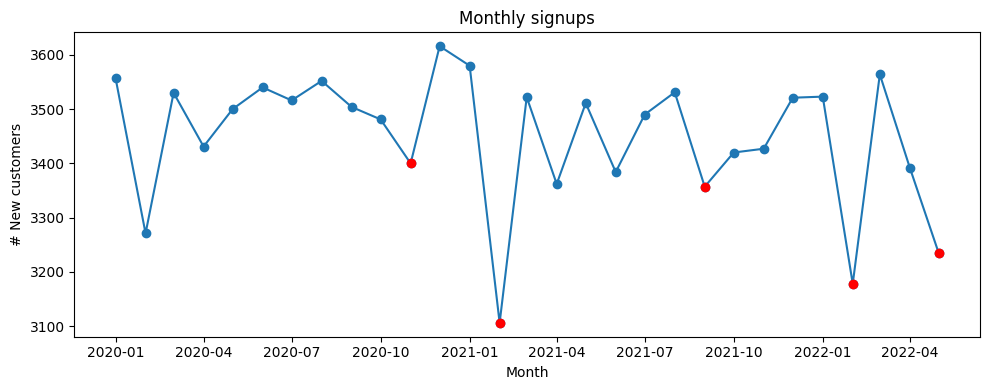

In [74]:

# Function to check the statistical significance of each drop, because i saw a large drop in february 2021, might be valuable insight for business for RCA
def drop_anomaly(series: pd.Series,
                 lookback: int = 6):
    y_last = series.iloc[-1]
    if len(series) < lookback + 1:
        return

    y_last = series.iloc[-1]
    baseline = series.iloc[-lookback-1:-1]

    # Simple one sided t-test
    mean = baseline.mean()
    sd = baseline.std()
    n  = len(baseline)
    error = sd / np.sqrt(n)

    t_stat = (y_last - mean) / error
    p_val  = stats.t.cdf(t_stat, df=n-1)
    
    print(f"Value {y_last}")

    return dict(last=y_last,
                mean_prev=mean,
                p_value=p_val,
                is_anomaly=p_val < 0.05)

monthly = main_df.groupby(main_df['Subscription Date'].dt.to_period('M')).size().sort_index()

is_anomaly = []
for i, datapoint in enumerate(monthly):
    result = drop_anomaly(monthly[:i+1], lookback=6)
    print(result)
    if result and result["is_anomaly"]:
        is_anomaly.append(True)
    else:
        is_anomaly.append(False)


fig1 = plt.figure(figsize=(10,4))
# highlight anomalies
anom_x = monthly.index.to_timestamp()[is_anomaly]
anom_y = monthly.values[is_anomaly]
plt.scatter(anom_x, anom_y, color='red', zorder=5, label='Anomaly')
plt.plot(monthly.index.to_timestamp(), monthly.values, marker='o', label='Monthly signups')
plt.title('Monthly signups')
plt.xlabel('Month')
plt.ylabel('# New customers')
plt.tight_layout()
plt.show()



Insight 1:

**Key takeaway**

* Revenue drop ada di banyak bulan, tapi yang perlu di investigate hanya yang statistically significant saja,
* di bulan-bulan yang di mark warna merah

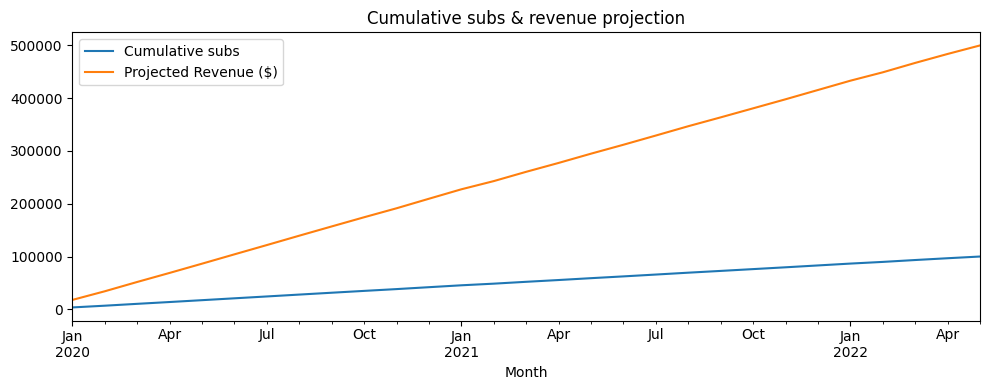

In [77]:
cum_subs = monthly.cumsum()
revenue  = cum_subs * 5

fig2 = plt.figure(figsize=(10,4))
cum_subs.plot(label='Cumulative subs')
revenue.plot(label='Projected Revenue ($)')
plt.title('Cumulative subs & revenue projection')
plt.xlabel('Month')
plt.legend()
plt.tight_layout()
plt.show()

Insight 2 : 
    Revenue growth is very-very stable, but i dont think this data is usable to business as theres no subscription cancel date, subscription contract period

Suggestion for data collection to business, add in contract period for each customer so we know their drop off period

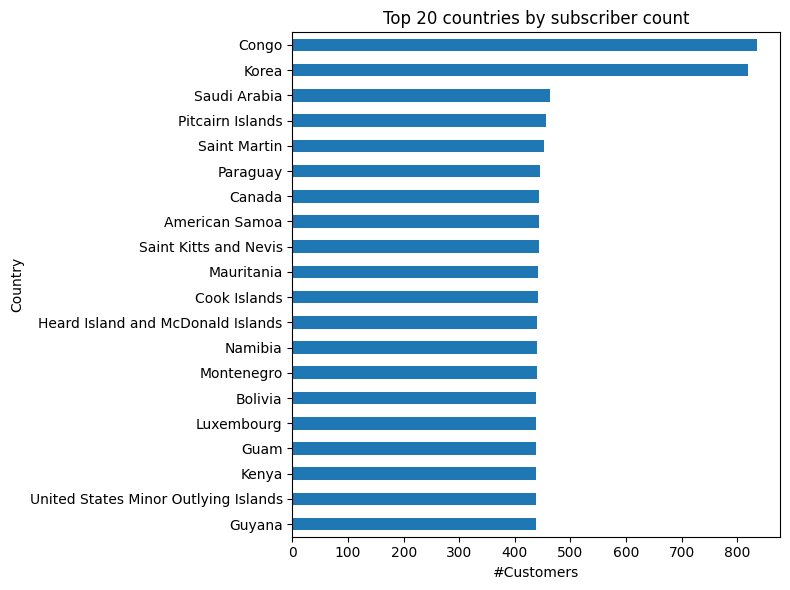

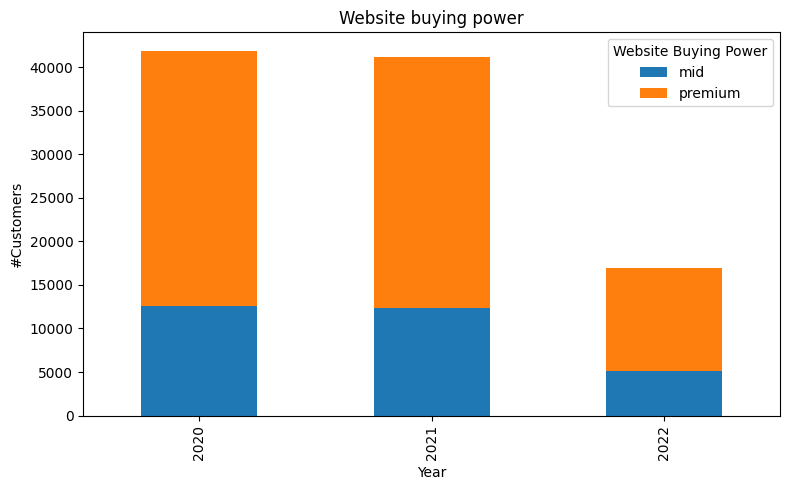

In [79]:
top_countries = main_df['Country'].value_counts().head(20).sort_values(ascending=True)

fig3 = plt.figure(figsize=(8,6))
top_countries.plot(kind='barh')
plt.title('Top 20 countries by subscriber count')
plt.xlabel('#Customers')
plt.tight_layout()
plt.show()


mix = pd.crosstab(main_df['Subscription Date'].dt.year, main_df['Website Buying Power'])
fig4 = plt.figure(figsize=(8,5))
mix.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Website buying power')
plt.xlabel('Year')
plt.ylabel('#Customers')
plt.tight_layout()
plt.show()

Insight 3 Country level Subscriber Mix

**Key takeaway**

* **Congo** and **Korea** each contribute roughly twice the subscribers of the next best market, **Saudi Arabia**.

**Nggak make sense, kenapa??**

* Rankingnya nggak match dengan macro reality GDP, population, and typical SaaS penetration don’t justify Congo or a single “Korea” on top.
* Korea may be an unsplit catch all that merges **South Korea (KR)** and **North Korea (KP)**, inflating the count?? need to check with business on this later on.